In [7]:
import pandas as pd
import numpy as np
import string as str
from os import listdir
from os.path import isfile, join
from  datetime import datetime
from os import listdir
from os.path import isfile, join

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import nltk.stem
from sklearn.decomposition import PCA

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.cross_validation import KFold

import plotly.plotly as py
import plotly.graph_objs as go

import matplotlib.pyplot as plt
%matplotlib inline  

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer


In [8]:
#single file
path='/home/ayush/Desktop/BigData_ProjectData/PlayStoreCsv/data/big_data2.csv'
df= pd.read_csv(path,sep=',',header=0)

#whole data
'''dfs=[]
path='../data/'
onlyfiles = [ f for f in listdir(path) if isfile(join(path,f)) and f.endswith( 'csv' ) ]
print onlyfiles
for eachFile in onlyfiles:
    path1='../data/'+eachFile
    df1= pd.read_csv(path1,sep=',',header=0)
    print df1.shape[0]
    dfs.append(df1)
df=pd.concat(dfs)
df.shape[0]'''

"dfs=[]\npath='../data/'\nonlyfiles = [ f for f in listdir(path) if isfile(join(path,f)) and f.endswith( 'csv' ) ]\nprint onlyfiles\nfor eachFile in onlyfiles:\n    path1='../data/'+eachFile\n    df1= pd.read_csv(path1,sep=',',header=0)\n    print df1.shape[0]\n    dfs.append(df1)\ndf=pd.concat(dfs)\ndf.shape[0]"

In [9]:
def mapBooleanColumns(x):
    if x==True:
        return 1
    else:
        return 0
    
def mappingScores(x):
    if x>0 and x<=1:
        return 1
    elif x>1 and x<=2:
        return 2
    elif x>2 and x<=3:
        return 3
    elif x>3 and x<=4:
        return 4
    else:
        return 5

def mapDates(d):
    d=d[:10]
    d1= datetime.now()
    d2=datetime.strptime(d, "%Y-%m-%d")
    return (d1.year - d2.year)*12 + d1.month - d2.month    
    
def seperateInstallations(col_name):
    return_data_type_as=None
    ls = col_name.str.split('-').str.get(0).str.strip(' ').str.replace(',','') #series object
    hs = col_name.str.split('-').str.get(1).str.strip(' ').str.replace(',','') #series object
    ls = ls.astype(float).fillna(0.0)
    hs = hs.astype(float).fillna(0.0)
    return ls, hs

def processAppSize(x):
    if x==-1:
        return 0.5
    else:
        return x

In [10]:
# Function to Vectorize 
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        english_stemmer = nltk.stem.SnowballStemmer('english')
        analyzer = super(StemmedCountVectorizer,self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))
    
def vectorize_column(dataframe,column_name,vectorizer=None):
    if vectorizer is None:
        print("No Vectorizer is explicitly specified. Using CountVectorizer as default one. ")
        column_vectorizer = CountVectorizer(min_df=1)
    else:
        column_vectorizer = vectorizer
    if column_name in dataframe.columns.values.tolist():
        column_df = dataframe[column_name]
        fmatrix = column_vectorizer.fit_transform(column_df)
        #print column_vectorizer.get_feature_names()
        #print("vectorized into matrix of shape"), fmatrix.toarray().shape
        dataframe_f = pd.DataFrame(fmatrix.toarray(), columns=column_vectorizer.get_feature_names())
        #print("formed dataframe of size:("),dataframe_f.index.max()+1,",", dataframe_f.head(1).shape[1],")"   
        return dataframe_f, fmatrix, column_vectorizer
    else:
        print("No column found")  
        
def vectorize_columnTfIdf(dataframe,column_name,vectorizer=None, n_samples=None, tf_idf=False):    
    more_stopwords  = ['00','000','0000','0003','0004','0004','0005'] 
    more_stopwords += stopwords.words('english')
    more_stopwords += stopwords.words('japanese') 
    more_stopwords += stopwords.words('chinese')
    more_stopwords += stopwords.words('arabic')
    more_stopwords += stopwords.words('korean')
    more_stopwords += stopwords.words('russian')    
    
    if vectorizer is None:
        print("No Vectorizer is explicitly specified. Using CountVectorizer as default one. ")
        column_vectorizer = CountVectorizer(min_df=1) #default vectorizer
    else:
        column_vectorizer = vectorizer
        column_vectorizer.stop_words = more_stopwords
    
    if column_name in dataframe.columns.values.tolist():
        
        if n_samples is None:
            column_df = dataframe[column_name] #select all the samples from the column passed as param. 
            print len(column_df)
        else:
            column_df = dataframe[column_name].iloc[0:n_samples] #select all the samples from the column passed as param.
            print len(column_df)
        
        fmatrix = column_vectorizer.fit_transform(column_df)   
        
        if(tf_idf is True):
            
            tfidf_transformer  = TfidfTransformer(norm='l2').fit(fmatrix)
            tfidfNormalzedmatrix = tfidf_transformer.transform(fmatrix)
            fmatrix = tfidfNormalzedmatrix
            
        dataframe_f = pd.DataFrame(fmatrix.todense(), columns=column_vectorizer.get_feature_names())
        print("formed dataframe of size:("),dataframe_f.index.max()+1,",", dataframe_f.head(1).shape[1],")"
        
        return dataframe_f, fmatrix, column_vectorizer
    else:
        print("No column found")

In [11]:
# Transforming the data into numerical forms
df.IsTopDeveloper=map(mapBooleanColumns,df.IsTopDeveloper)
df.HaveInAppPurchases=map(mapBooleanColumns,df.HaveInAppPurchases)
df.IsFree=map(mapBooleanColumns,df.IsFree)
df.Score=map(mappingScores,df.Score)
df.PublicationDate=map(mapDates,df.PublicationDate)
df.LastUpdateDate=map(mapDates,df.LastUpdateDate)
df['minInstall'],df['maxInstall']=seperateInstallations(df.Instalations)
df.AppSize=map(processAppSize,df.AppSize)

In [12]:
# Selecting Features
df=df.head(n=500)
X=df[['Price','PublicationDate','AppSize','LastUpdateDate','IsFree','HaveInAppPurchases','minInstall','maxInstall']]
y=pd.DataFrame(df[['Score']])

In [13]:
# Vectorising the features and merging them to selected numerical features     
s= nltk.stem.SnowballStemmer('english')
s.stem("graphics")

stem_vectorizer = StemmedCountVectorizer(min_df =1, stop_words='english')
# Vectorizing the Category Column
nCategory, fmatrix, column_vectorizer = vectorize_columnTfIdf(df, 'Category', stem_vectorizer,df.shape[0],True)
# Vectorizing the Name Column
nName, fmatrix1, column_vectorizer1 = vectorize_columnTfIdf(df, 'Name', stem_vectorizer,df.shape[0],True)
# Vectorizing the Description Column
nDescription, fmatrix2, column_vectorizer2 = vectorize_columnTfIdf(df, 'Description',stem_vectorizer,df.shape[0],True)
# Vectorizing the Content Rating Column
nContentRating, fmatrix3, column_vectorizer3 = vectorize_columnTfIdf(df, 'ContentRating',stem_vectorizer,df.shape[0],True)

finaldf = pd.concat([X,nCategory,nName,nDescription,nContentRating],axis=1)



500
formed dataframe of size:( 500 , 32 )
500
formed dataframe of size:( 500 , 681 )
500
formed dataframe of size:( 500 , 7321 )
500
formed dataframe of size:( 500 , 8 )


In [14]:
def getClassifierName(clf):
    if type(clf).__name__ != 'OneVsRestClassifier':
        #print type(clf).__name__
        return type(clf).__name__
    else:
        #print type(clf.estimator).__name__ 
        return type(clf.estimator).__name__

In [16]:
resultpath='/home/ayush/Desktop/clf_results/'
resultFile=open(resultpath+'Results_Classifier'+'.csv', 'w+')
resultFile.write('Components,Classifier,Accuracy,Precision,Recall')

In [17]:
#resultpath='../clf_results/'
n_components=[20,100,200,500,1000,finaldf.shape[1]]
#n_components=[2,6,8]
#n_components=[20,30,40]

n_kfolds=4

classifiers = [GaussianNB(),BernoulliNB(),RandomForestClassifier(),LogisticRegression(),SGDClassifier(),RidgeClassifier()
              ,DecisionTreeClassifier()]
classifierName=['GaussianNB','Bernauli','RandomForest','LogisticRegression','SDGC','RidgeClassifier','DecsionTree']
n_component_accuracies = []

for n in n_components:
    xx=finaldf.copy()
    pca = PCA(n_components=n)
    xx= pca.fit_transform(xx)
    yy=y.values
    accuracies=[]
    for clf in classifiers:
            clfname=getClassifierName(clf)
            print len(xx),clfname
            kf = KFold(len(xx),n_kfolds)
            accuracy=0
            precision=0
            recall=0
            for train_index,test_index in kf:
                X_train, X_test, y_train, y_test = xx[train_index],xx[test_index],yy[train_index],yy[test_index]
                clf.fit(X_train,y_train)                
                y_pred=clf.predict(X_test)
                accScore=accuracy_score(y_test,y_pred)
                precisionScore=precision_score(y_test,y_pred)
                recallScore=recall_score(y_test,y_pred)
                #print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0],(y_test != y_pred).sum()))
                accuracy += accScore
                precision += precisionScore
                recall += recallScore
            print("Components:%f Classifier:%s Accuracy Score:%f"%(n,clf,accuracy/n_kfolds)) 
            resultFile.write("\n%f,%s,%0.3f,%0.3f,%0.3f"%(n,clfname,accuracy/n_kfolds,precision/n_kfolds,recall/n_kfolds))
            accuracies.append(accuracy/n_kfolds) 
    n_component_accuracies.append(accuracies)  

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr

500 GaussianNB
Components:20.000000 Classifier:GaussianNB() Accuracy Score:0.314000
500 BernoulliNB
Components:20.000000 Classifier:BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) Accuracy Score:0.504000
500 RandomForestClassifier
Components:20.000000 Classifier:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Accuracy Score:0.510000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:28: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recal


500 LogisticRegression
Components:20.000000 Classifier:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0) Accuracy Score:0.564000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


500 SGDClassifier
Components:20.000000 Classifier:SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False) Accuracy Score:0.196000
500 RidgeClassifier
Components:20.000000 Classifier:RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='auto', tol=0.001) Accuracy Score:0.564000
500 DecisionTreeClassifier
Components:20.000000 Classifier:DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best') Accuracy Score:0.474000
500

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr

 GaussianNB
Components:100.000000 Classifier:GaussianNB() Accuracy Score:0.406000
500 BernoulliNB
Components:100.000000 Classifier:BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) Accuracy Score:0.456000
500 RandomForestClassifier
Components:100.000000 Classifier:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Accuracy Score:0.536000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:28: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recal


500 LogisticRegression
Components:100.000000 Classifier:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0) Accuracy Score:0.566000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


500 SGDClassifier
Components:100.000000 Classifier:SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False) Accuracy Score:0.248000
500 RidgeClassifier
Components:100.000000 Classifier:RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='auto', tol=0.001) Accuracy Score:0.558000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of 


500 DecisionTreeClassifier
Components:100.000000 Classifier:DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best') Accuracy Score:0.460000
500

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr

 GaussianNB
Components:200.000000 Classifier:GaussianNB() Accuracy Score:0.472000
500 BernoulliNB
Components:200.000000 Classifier:BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) Accuracy Score:0.456000
500 RandomForestClassifier
Components:200.000000 Classifier:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Accuracy Score:0.492000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:28: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recal


500 LogisticRegression
Components:200.000000 Classifier:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0) Accuracy Score:0.564000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


500 SGDClassifier
Components:200.000000 Classifier:SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False) Accuracy Score:0.092000
500 RidgeClassifier
Components:200.000000 Classifier:RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='auto', tol=0.001) Accuracy Score:0.514000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of 


500 DecisionTreeClassifier
Components:200.000000 Classifier:DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best') Accuracy Score:0.504000
500

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr

 GaussianNB
Components:500.000000 Classifier:GaussianNB() Accuracy Score:0.430000
500 BernoulliNB
Components:500.000000 Classifier:BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) Accuracy Score:0.488000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:28: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recal


500 RandomForestClassifier
Components:500.000000 Classifier:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Accuracy Score:0.484000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


500 LogisticRegression
Components:500.000000 Classifier:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0) Accuracy Score:0.568000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


500 SGDClassifier
Components:500.000000 Classifier:SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False) Accuracy Score:0.074000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of 


500 RidgeClassifier
Components:500.000000 Classifier:RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='auto', tol=0.001) Accuracy Score:0.554000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted


500 DecisionTreeClassifier
Components:500.000000 Classifier:DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best') Accuracy Score:0.472000
500

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr

 GaussianNB
Components:1000.000000 Classifier:GaussianNB() Accuracy Score:0.430000
500 BernoulliNB
Components:1000.000000 Classifier:BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) Accuracy Score:0.488000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


500 RandomForestClassifier
Components:1000.000000 Classifier:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Accuracy Score:0.534000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


500 LogisticRegression
Components:1000.000000 Classifier:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0) Accuracy Score:0.568000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


500 SGDClassifier
Components:1000.000000 Classifier:SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False) Accuracy Score:0.062000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of 


500 RidgeClassifier
Components:1000.000000 Classifier:RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='auto', tol=0.001) Accuracy Score:0.554000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted


500 DecisionTreeClassifier
Components:1000.000000 Classifier:DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best') Accuracy Score:0.486000
500

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr

 GaussianNB
Components:8050.000000 Classifier:GaussianNB() Accuracy Score:0.430000
500 BernoulliNB
Components:8050.000000 Classifier:BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) Accuracy Score:0.488000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


500 RandomForestClassifier
Components:8050.000000 Classifier:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Accuracy Score:0.468000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


500 LogisticRegression
Components:8050.000000 Classifier:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0) Accuracy Score:0.568000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of pr


500 SGDClassifier
Components:8050.000000 Classifier:SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False) Accuracy Score:0.144000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of 


500 RidgeClassifier
Components:8050.000000 Classifier:RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='auto', tol=0.001) Accuracy Score:0.554000

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted


500 DecisionTreeClassifier
Components:8050.000000 Classifier:DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best') Accuracy Score:0.488000


/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning:

The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".



In [19]:
# Plotting the graph
plotarrays=np.array(n_component_accuracies)
'''data = []
for i in range(0,len(classifiers)):
    a=plotarrays[:,i]
    trace = go.Scatter(
        x = n_components,
        y = a,
        name=classifierName[i]
    )
    data.append(trace)


# Plot and embed in ipython notebook!
layout = go.Layout(
    title='Accuracies for various classifiers',
    yaxis=dict(title='Accuracy'),
    xaxis=dict(title='Number of Features after PCA')
)
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='basic-line')
'''

"data = []\nfor i in range(0,len(classifiers)):\n    a=plotarrays[:,i]\n    trace = go.Scatter(\n        x = n_components,\n        y = a,\n        name=classifierName[i]\n    )\n    data.append(trace)\n\n\n# Plot and embed in ipython notebook!\nlayout = go.Layout(\n    title='Accuracies for various classifiers',\n    yaxis=dict(title='Accuracy'),\n    xaxis=dict(title='Number of Features after PCA')\n)\nfig = dict(data=data, layout=layout)\npy.iplot(fig, filename='basic-line')\n"

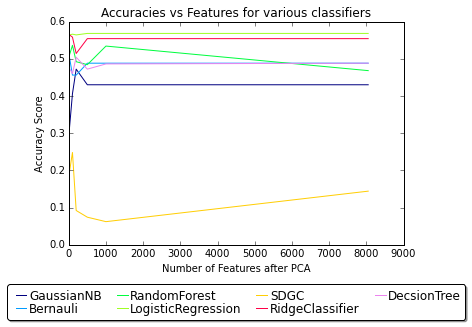

In [20]:
if(True):
    # Plot using matplotlib
    num_plots = len(classifiers)
    colormap = plt.cm.gist_ncar
    plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)])
    # Plot several different functions...
    labels = []
    for i in range(0, num_plots):
        a=plotarrays[:,i]
        #print n_components ,a
        plt.plot(n_components,a)
        labels.append(classifierName[i])

    plt.legend(labels, ncol=4, loc='upper center', 
               bbox_to_anchor=[0.5, -0.15], 
               columnspacing=1.0, labelspacing=0.0,
               handletextpad=0.0, handlelength=1.5,
               fancybox=True, shadow=True)
    
    plt.xlabel('Number of Features after PCA')
    plt.ylabel('Accuracy Score')
    plt.title('Accuracies vs Features for various classifiers')

    #plt.show()
    plt.savefig(resultpath+'Result_classifier')